In [1]:
import numpy as np
#import seaborn as sns
#import matplotlib.pyplot as plt
import csv
#import networkx as nx
import pickle
from scipy import stats

import sys
sys.path.insert(1, '../../')
from utils import *

In [2]:
#dataset = 'hospital'
#dataset = 'high_school'
#dataset = 'conference'
#dataset = 'workplace'
dataset = 'pr_school'

In [3]:
weighted = True

In [4]:
a_inf = 0.8
a_sup = 0.9

In [5]:
mu = 0.1

if dataset == 'hospital':
    beta_betaT_range = [(0.6,0.8),
                        (0.2,0.8),
                        (0.3,5),
                        (0.4,7.5),
                        (0.15,5),
                        (0.3,10),
                        (0.1,10),
                        (0.06,10),
                        (0.05,15),
                        (0.05,19)]
#elif dataset == 'high_school':
#    beta_betaT_range = [(0.7,5),(0.9,5),(0.7,7),(1,7),(0.7,1),(1,1)]
elif dataset == 'conference':
    beta_betaT_range = [(1,12),
                        (0.9,12),
                        (0.8,12),
                        (0.7,12),
                        (0.6,12),
                        (0.5,12)]
elif dataset == 'workplace':
    beta_betaT_range = [(0.5,6),
                        (0.3,6),
                        (0.3,7),
                        (0.5,7),
                        (0.3,7.3),
                        (0.4,7.3),
                        (0.3,6.5)]
elif dataset == 'pr_school':
    beta_betaT_range = [(0.07,7),
                        (0.1,7),
                        (0.1,5),
                        (0.2,7),
                        (0.15,5),
                        (0.2,5),
                        (0.2,3),
                        (0.2,1),
                        ]

# Load C and obtain r and s:

C is an array of weights, I need to put it in a matrix shape to compute r and s

In [6]:
def obtain_r_s_indices(C,edgelist):
    # put C in dict:
    C_dict = {}
    n = 0
    for edge in edgelist:
        C_dict[tuple(edge)] = C[n]
        C_dict[tuple(edge[::-1])] = C[n+1]
        n += 2
    # verify:
    if list(C_dict.values()) != list(C):
        print('error')
    nb_nodes = max(np.unique(list(C_dict.keys()))) + 1
    # put C_dict in matrix:
    C_mat = np.zeros((nb_nodes,nb_nodes))
    for link in C_dict:
        C_mat[link[0],link[1]] = C_dict[link]

    # receiver index:
    r = C_mat.sum(axis=0) # somma di ogni colonna
    # spreader index:
    s = C_mat.sum(axis=1) # somma di ogni riga

    return r, s

In [7]:
with open('../../data/pairwise/' + dataset + '_strength_edgelist_pairwise_sorted.pkl', 'rb') as f:
    edgelist = pickle.load(f)

In [8]:
r_list = []
s_list = []
for (beta,betaT) in beta_betaT_range:
    filename = "results/inf_treeSIR_all/a_%.1f_%.1f_final/CL_weighted_%s_beta_%.3f_betaT_%.3f_mu_%.3f.csv"%(a_inf,a_sup,dataset,beta,betaT,mu)
    CL_list_tmp = load_C_list(filename)
    CL_mean = np.mean(CL_list_tmp,axis=0)
    #CL_list.append(CL_mean)
    filename = "results/inf_treeSIR_all/a_%.1f_%.1f_final/CT_weighted_%s_beta_%.3f_betaT_%.3f_mu_%.3f.csv"%(a_inf,a_sup,dataset,beta,betaT,mu)
    CT_list_tmp = load_C_list(filename)
    CT_mean = np.mean(CT_list_tmp,axis=0)
    #CT_list.append(CT_mean)
    #C_list.append(CL_mean+CT_mean)
    C_mean = CL_mean+CT_mean
    # verify:
    #if 2*len(edgelist) != len(C):
    #    print('errore')
    r, s = obtain_r_s_indices(C_mean,edgelist)
    r_list.append(r)
    s_list.append(s)
    

In [9]:
#r_list[0]

# Cosine similarity

### Receiver index

In [10]:
sim_r = np.full((len(beta_betaT_range),len(beta_betaT_range)),0.0)
for i in range(len(beta_betaT_range)-1):
    for j in range(i+1,len(beta_betaT_range)):
        sim_r[i,j] = cos_sim(r_list[i],r_list[j] )

0.9982584928596672 0.9998184605847589
../figs/simplicial_cos_sim_receiver_pr_school_mu_0.10_fixed_a_0.8_0.9.pdf.pdf


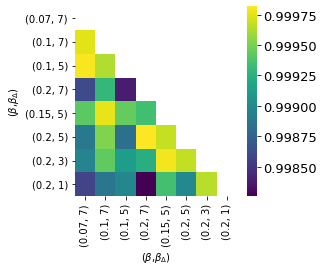

In [11]:
title='$r_i$ cosine sim.'
figname = '../figs/receiver_cos_sim_%s_mu_%.2f_fixed_a_%.1f_%.1f.pdf'%(dataset,mu,a_inf,a_sup)

plot_sim(sim_r, 
         mu, 
         beta_betaT_range,
         r'($\beta$,$\beta_{\Delta}$)',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

### Spreader index

In [12]:
sim_s = np.full((len(beta_betaT_range),len(beta_betaT_range)),0.0)
for i in range(len(beta_betaT_range)-1):
    for j in range(i+1,len(beta_betaT_range)):
        sim_s[i,j] = cos_sim(s_list[i],s_list[j] )

0.9868778491922895 0.9992478437052409
../figs/simplicial_cos_sim_spreader_pr_school_mu_0.10_fixed_a_0.8_0.9.pdf.pdf


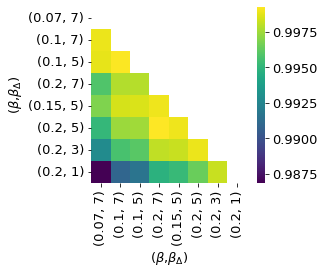

In [13]:
title='$s_i$ cosine sim.'
figname = '../figs/spreader_cos_sim_%s_mu_%.2f_fixed_a_%.1f_%.1f.pdf'%(dataset,mu,a_inf,a_sup)

plot_sim(sim_s, 
         mu, 
         beta_betaT_range,
         r'($\beta$,$\beta_{\Delta}$)',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

# Ranking correlation

### Receiver index

In [14]:
corr_r = np.full((len(beta_betaT_range),len(beta_betaT_range)),0.0)
for i in range(len(beta_betaT_range)-1):
    for j in range(i+1,len(beta_betaT_range)):
        corr_r[i,j] = stats.spearmanr(np.array(r_list[i]),np.array(r_list[j])).correlation

0.944518051689433 0.9850960163587681
../figs/simplicial_rank_corr_receiver_pr_school_mu_0.10_fixed_a_0.8_0.9.pdf.pdf


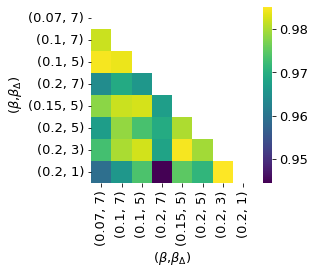

In [15]:
title='$r_i$ ranking corr.'
figname = '../figs/receiver_rank_corr_%s_mu_%.2f_fixed_a_%.1f_%.1f.pdf'%(dataset,mu,a_inf,a_sup)

plot_sim(corr_r, 
         mu, 
         beta_betaT_range,
         r'($\beta$,$\beta_{\Delta}$)',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

### Spreader index

In [16]:
corr_s = np.full((len(beta_betaT_range),len(beta_betaT_range)),0.0)
for i in range(len(beta_betaT_range)-1):
    for j in range(i+1,len(beta_betaT_range)):
        corr_s[i,j] = stats.spearmanr(np.array(s_list[i]),np.array(s_list[j])).correlation

0.9799774855728585 0.9984149301388079
../figs/simplicial_rank_corr_spreader_pr_school_mu_0.10_fixed_a_0.8_0.9.pdf.pdf


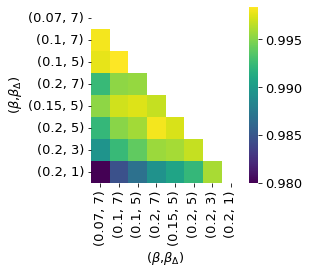

In [17]:
title='$s_i$ ranking corr.'
figname = '../figs/spreader_rank_corr_%s_mu_%.2f_fixed_a_%.1f_%.1f.pdf'%(dataset,mu,a_inf,a_sup)

plot_sim(corr_s, 
         mu, 
         beta_betaT_range,
         r'($\beta$,$\beta_{\Delta}$)',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

# Receiver vs. spreader

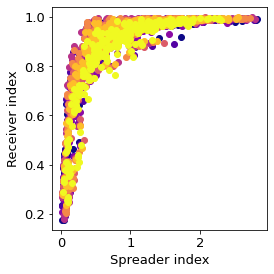

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize=(4,4))

colors = plt.cm.plasma(np.linspace(0,1,len(beta_betaT_range)))
for i in range(len(beta_betaT_range)):
    plt.plot(np.array(s_list[i]),
             np.array(r_list[i]),
             'o',
             c=colors[i],
             label=r'%.2f,%d'%(beta_betaT_range[i][0],beta_betaT_range[i][1]))
plt.xlabel('Spreader index')
plt.ylabel('Receiver index')
plt.tight_layout()
#plt.legend(title=r'$\beta$,$\beta_{\Delta}$')
plt.savefig('../figs/r_s_simplicial_%s_fixed_a_%.1f_%.1f.pdf'%(dataset,a_inf,a_sup))
#plt.savefig('../figs/legend.pdf')